In [1]:
import numpy as np, pandas as pd, pymc as pm, matplotlib.pyplot as plt, dismod_mr
%matplotlib inline

# Anxiety in Conflict

In [2]:
# set random seed for reproducibility
np.random.seed(12345)

In [3]:
mdd = dismod_mr.data.load('data/dm-40553')

/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/data.py:595: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  d.output_template = pd.DataFrame.from_csv(path + '/output_template.csv')


In [4]:
df = pd.io.excel.read_excel('data/literature_data.xlsx', 'Anxiety data cleaned')

def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
    
assert float_or_nan(1) == 1
assert np.isnan(float_or_nan('-'))

In [5]:
assert np.all(~df.Age_start.isnull())
assert np.all(~df.Age_end.isnull())

# # fill in missing age start and age end
# assert np.isnan(df.loc[10, 'Age_start'])
# df.loc[10, 'Age_start'] = 0

# assert np.isnan(df.loc[10, 'Age_end'])
# df.loc[10, 'Age_end'] = 100

In [6]:
dm = dismod_mr.data.ModelData()

inp = pd.DataFrame(columns=dm.input_data.columns, index=df.index)

# data type, value, and uncertainty
inp.data_type = 'p'
inp.value = df.Parameter_value / df.Units
inp.effective_sample_size = df.Denominator

# geographic information (to be used for random effects)
inp.area = df.Country
#inp.area = df.Super_region.astype(str)

inp.sex = df.Sex.map({'Male':'male', 'Female':'female', 'Total':'total'})
inp.age_start = df.Age_start
inp.age_end = df.Age_end

inp.standard_error = np.nan
inp.upper_ci = np.nan
inp.lower_ci = np.nan

# setup model
dm.parameters['p'] = mdd.parameters['p'].copy()
dm.set_decreasing('p', 85, 101)
for i, row in df.iterrows():  # FIXME: cast-to-string currently need, unicode strings fail
    dm.hierarchy.add_edge('all', str(row['Country']))
    #dm.hierarchy.add_edge('all', str(row['Super_region']))
    #dm.hierarchy.add_edge(str(row['Super_region']), str(row['GBD_region']))
    #dm.hierarchy.add_edge(str(row['GBD_region']), str(row['Country']))

In [7]:
def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
    
assert float_or_nan(1) == 1
assert np.isnan(float_or_nan('-'))

In [8]:
# time since conflict categorical vars
for i in [3,1]:
    col = 'x_tsc_%d'%i
    inp[col] = df.Time_since_conflict_years==i

inp['x_length_of_conflict_geq_25'] = df.Length_of_conflict.map(float_or_nan) >= 25
inp['x_administration_method'] = df.Method_administration == 'Lay-interviewer'
inp['x_symptom_scale'] = df['Symptom scale_coded']  # all zero?


# TODO: Want to look at symptom scale, method of administration, time since conflict, length of conflict

In [9]:
inp.head()

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size,lower_ci,upper_ci,age_weights,x_tsc_3,x_tsc_1,x_length_of_conflict_geq_25,x_administration_method,x_symptom_scale
0,p,0.014706,Pakistan,male,18,80,NaN,NaN,NaN,408.000000,NaN,NaN,NaN,False,False,False,True,0
1,p,0.034000,Lebanon,male,60,99,NaN,NaN,NaN,287.000000,NaN,NaN,NaN,True,False,True,True,0
2,p,0.031000,Israel,male,14,17,NaN,NaN,NaN,497.000000,NaN,NaN,NaN,False,False,True,False,0
3,p,0.021000,Northern Ireland,male,18,64,NaN,NaN,NaN,523.809524,NaN,NaN,NaN,False,False,False,False,0
4,p,0.024000,Northern Ireland,male,18,64,NaN,NaN,NaN,458.333333,NaN,NaN,NaN,False,False,False,False,0


In [10]:
# add additional data rows to obtain output estimates for requested age groups
ages = [[0,10],
        [10,20],
        [20,30],
        [30,40],
        [40,50],
        [50,60],
        [60,70],
        [70,80]]
for age_start, age_end in ages:
    inp = inp.append(pd.Series({'data_type':'p',
                                'value': 0,
                                'effective_sample_size':0,
                                'area': 'all',
                                'sex': 'total',
                                'age_start': age_start,
                                'age_end': age_end,
                                'x_tsc_3': False,
                                'x_tsc_1': False,
                                'x_length_of_conflict_geq_25': False,
                                'x_administration_method': False,
                                'x_symptom_scale': 0                                
                                }), ignore_index=True)

In [11]:
inp.tail()

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size,lower_ci,upper_ci,age_weights,x_tsc_3,x_tsc_1,x_length_of_conflict_geq_25,x_administration_method,x_symptom_scale
83,p,0.0,all,total,30,40,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
84,p,0.0,all,total,40,50,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
85,p,0.0,all,total,50,60,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
86,p,0.0,all,total,60,70,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
87,p,0.0,all,total,70,80,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0


In [12]:
dm.input_data = inp.copy()

columns = dm.input_data.filter(like='x_').columns
dm.input_data.loc[:, columns] = dm.input_data.loc[:, columns].astype(float)

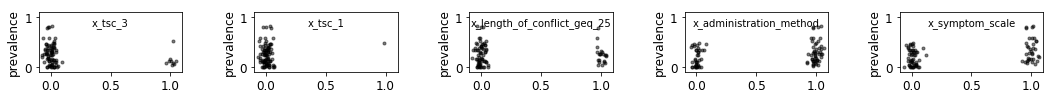

In [13]:
# set mpl defaults for nice display
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['lines.linewidth'] = 1
    
X = inp.filter(like='x_')
y = inp.value
for i, c_i in enumerate(X.columns):
    plt.subplot(4,5,1+i)
    plt.title('\n'+c_i, va='top', fontsize=10)
    plt.ylabel('prevalence')
    plt.plot(X[c_i]+np.random.normal(size=len(y))*.03, y, 'k.', alpha=.5)
    plt.axis(xmin=-.1, xmax=1.1, ymin=-.1, ymax=1.1)
    plt.subplots_adjust(hspace=.5, wspace=.5)

In [14]:
#dm.set_knots('p', [0, 2, 4, 6, 8, 10, 25, 55, 100])
#dm.set_knots('p', [0,3,10,20,30,45,55,70,85,100])
dm.set_knots('p', [0,2,4,6,8,10,15,20,25,30,45,85])
#dm.set_knots('p', [0, 10, 20, 30, 85])
dm.set_decreasing('p', 100, 100)
dm.parameters['ages'] = range(0,86)

In [15]:
dm.parameters['p']

{'decreasing': {'age_end': 100, 'age_start': 100},
 'fixed_effects': {},
 'heterogeneity': 'Very',
 'increasing': {'age_end': 0, 'age_start': 0},
 'level_bounds': {'lower': 0.0, 'upper': 1.0},
 'level_value': {'age_after': 100, 'age_before': 3, 'value': '0.0'},
 'parameter_age_mesh': [0, 2, 4, 6, 8, 10, 15, 20, 25, 30, 45, 85],
 'random_effects': {},
 'smoothness': {'age_end': 100, 'age_start': 0, 'amount': 'Slightly'},
 'y_maximum': 1.0}

In [16]:
dm.setup_model(rate_type='p', rate_model='neg_binom')

/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/model/covariates.py:84: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/model/covariates.py:98: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/snfs2/HOME/abie/projects/2016/dismod_mr/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)
/snfs2/HOME/

In [17]:
def invalid_precision(dm):
    return dm.input_data.effective_sample_size.isnull() \
      & dm.input_data.standard_error.isnull() \
      & (dm.input_data.lower_ci.isnull() | dm.input_data.upper_ci.isnull())
dm.input_data[invalid_precision(dm)]

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size,lower_ci,upper_ci,age_weights,x_tsc_3,x_tsc_1,x_length_of_conflict_geq_25,x_administration_method,x_symptom_scale
13,p,0.066,Mexico,total,18,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0


In [18]:
FAST = False  # set this to True to exercise code, keep as False to reproduce published results

if FAST == True:
    %time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)
else:
    %time dm.fit(how='mcmc', iter=1000000, burn=500000, thin=500)

finding initial values
.
.
.

finding MAP estimate

finding step covariances estimate

resetting initial values (1)
.
.
.

resetting initial values (2)

mare: 0.48
sampling from posterior

CPU times: user 1d 14min 47s, sys: 15 s, total: 1d 15min 2s
Wall time: 1d 1h 10min 49s


In [19]:
from matplotlib.pylab import *

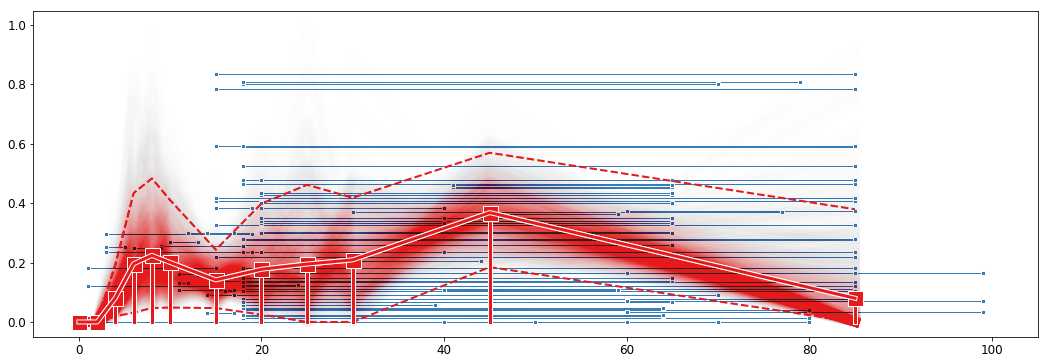

In [20]:
def plot(self, rate_type=None):
    import matplotlib.pyplot as plt, numpy as np
    import dismod_mr.plot as plot

    if rate_type or 'rate_type' in self.model_settings:
        plot_types = self.model_settings.get('rate_type', rate_type)
    else:
        plot_types = ['p', 'i', 'r', 'f']

    fig = plt.figure()

    for i, t in enumerate(plot_types):
        if len(plot_types) == 4:
            plt.subplot(2, 2, i+1)
            plt.title(t)
            plt.subplots_adjust(hspace=.5, wspace=.4)

        a0 = self.parameters['ages'][0]

        plot.data_bars(self.get_data(t), color=plot.colors[1])

        if t in self.vars:
            x = np.array(self.parameters['ages'])
            knots = self.vars[t].get('knots', np.array([]))

            if not hasattr(self.vars[t]['mu_age'], 'trace'):
                pt = self.vars[t]['mu_age'].value
                plt.plot(x, pt, linewidth=3, color=plot.colors[0])
                if len(knots) > 0:
                    plt.plot(knots, pt[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])
            else:

                pred = self.vars[t]['mu_age'].trace()
                import pymc as mc
                ui =mc.utils.hpd(pred, .05)

                if len(knots) > 0:
                    plt.plot(x[knots-a0], ui[:, knots-a0].T, '--', linewidth=2, color=plot.colors[0], alpha=1)
                else:
                    plt.plot(x, ui, '--', linewidth=2, color=plot.colors[0], alpha=1)

                plt.plot(x, pred.T, linewidth=10, color=plot.colors[0], alpha=.005)
                plt.plot(self.parameters['ages'], pred.mean(0), linewidth=5, color='w')

                if len(knots) > 0:
                    xx = []
                    yy = []
                    for k_i in knots:
                        xx += [k_i, k_i, np.nan]
                        yy += [0., pred.mean(axis=0)[k_i-a0], np.nan]
                    plt.plot(xx, yy, linewidth=5, color='w')
                    plt.plot(xx, yy, linewidth=3, color=plot.colors[0])
                    plt.plot(self.parameters['ages'], pred.mean(0), linewidth=3, color=plot.colors[0])
                    plt.plot(knots, pred.mean(axis=0)[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])

                import pymc as mc
                ui =mc.utils.hpd(pred, .05)
                plt.plot(x, pred.mean(0), linewidth=5, color='w')
                plt.plot(x, pred.mean(0), linewidth=3, color=plot.colors[0])

        plt.axis(xmin=-5, xmax=105)


plot(dm)
plt.savefig('anxiety_conflict_age.png')
#dismod_mr.plot.effects(dm, 'p', figsize=(18,12))
#plt.savefig('anxiety_conflict_effects.png')

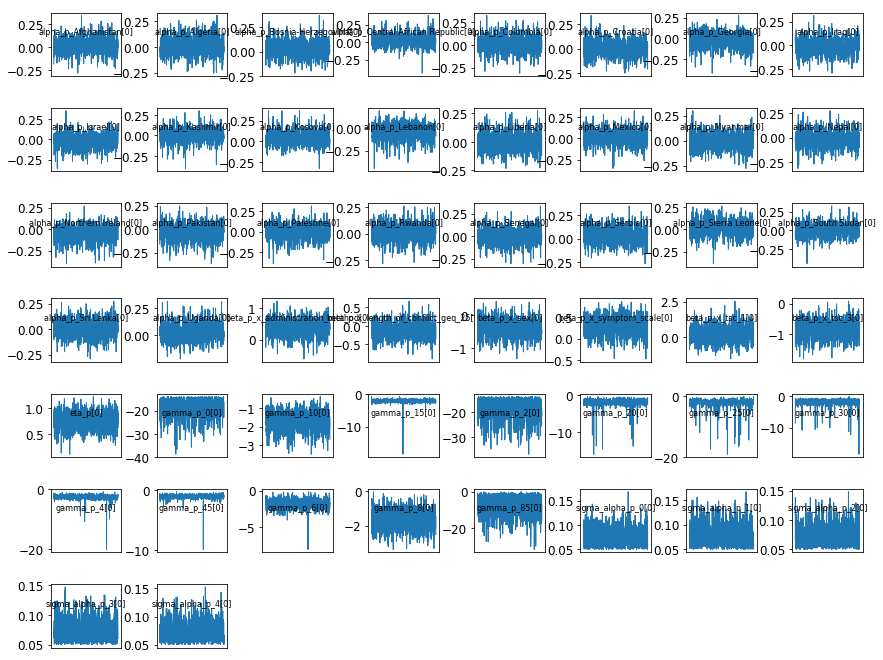

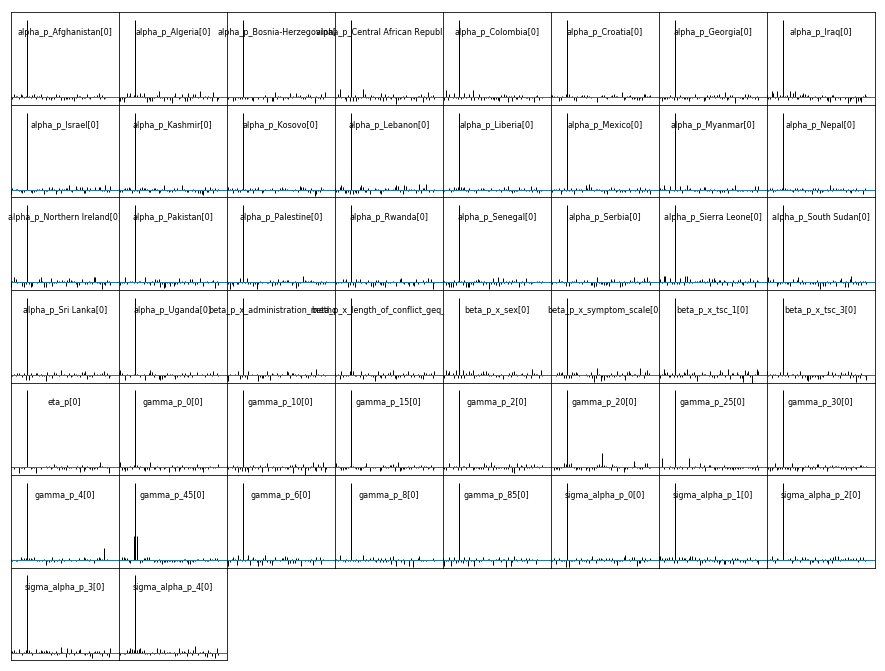

In [21]:
def plot_trace(model):
    def show_trace(trace):
        plt.plot(trace)
        plt.xticks([])

    plot_viz_of_stochs(model.vars, show_trace, (12,9))
    plt.subplots_adjust(.05,.01,.99,.99,.5,.5)

def plot_acorr(model):
    from matplotlib import mlab
    def acorr(trace):
        if len(trace) > 50:
            plt.acorr(trace, normed=True, detrend=mlab.detrend_mean, maxlags=50)
        plt.xticks([])
        plt.yticks([])
        l,r,b,t = plt.axis()
        plt.axis([-10, r, -.1, 1.1])

    plot_viz_of_stochs(model.vars, acorr, (12,9))
    plt.subplots_adjust(0,0,1,1,0,0)


def plot_viz_of_stochs(vars, viz_func, figsize=(8,6)):
    """ Plot autocorrelation for all stochs in a dict or dict of dicts

    :Parameters:
      - `vars` : dictionary
      - `viz_func` : visualazation function such as ``acorr``, ``show_trace``, or ``hist``
      - `figsize` : tuple, size of figure

    """
    plt.figure(figsize=figsize)

    cells, stochs = dismod_mr.plot.tally_stochs(vars)

    # for each stoch, make an autocorrelation plot for each dimension
    rows = np.floor(np.sqrt(cells))
    cols = np.ceil(cells/rows)

    tile = 1
    for s in sorted(stochs, key=lambda s: s.__name__):
        trace = s.trace()
        if len(trace.shape) == 1:
            trace = trace.reshape((len(trace), 1))
        for d in range(len(np.atleast_1d(s.value))):
            plt.subplot(rows, cols, tile)
            viz_func(np.atleast_2d(trace)[:, d])
            plt.title('\n\n%s[%d]'%(s.__name__, d), va='top', ha='center', fontsize=8)
            tile += 1

plot_trace(dm)
plot_acorr(dm)

[-5, 105, -0.3941426193963895, 0.6545800317576158]

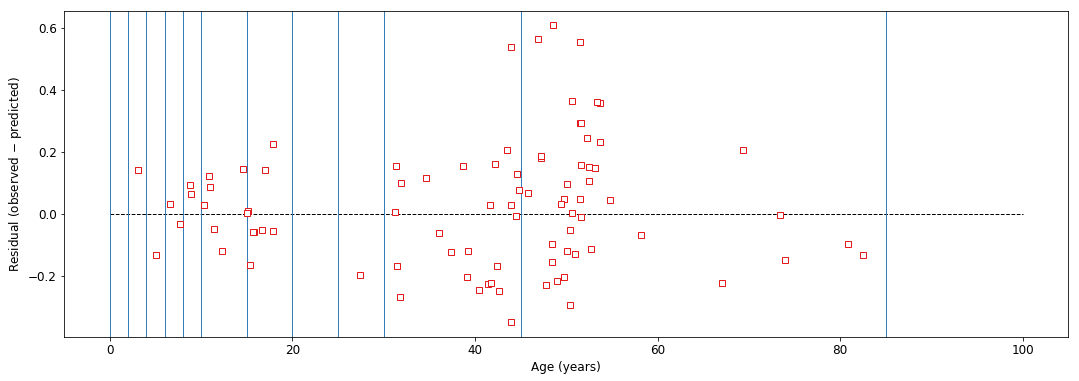

In [22]:
inp = dm.input_data
plt.plot((inp.age_start+inp.age_end)/2 + 2*np.random.randn(len(inp.index)),
     inp.value - dm.vars['p']['mu_interval'].trace().mean(axis=0), 's',
        mec=dismod_mr.plot.colors[0], mew=1, color='w')
hlines([0],0,100, linestyle='dashed')
xlabel('Age (years)')
ylabel('Residual (observed $-$ predicted)')
l,r,b,t = axis()
vlines(dm.parameters['p']['parameter_age_mesh'],-1,1, linestyle='solid', color=dismod_mr.plot.colors[1])
axis([-5,105,b,t])


In [23]:
countries = list(dm.input_data.area.unique())

dm.output_template = pd.DataFrame(dict(area=countries+countries,
                                       sex=['male']*len(countries) + ['female']*len(countries)))

for cov in dm.input_data.filter(like='x_'):
    dm.output_template[cov] = 0.

# FIXME: need to fill in correct UN_HDI value for given country/year
#dm.output_template['x_UN_HDI'] = df.UN_HDI.max()


dm.output_template['pop'] = 1  # pop is important for aggregating multiple areal units, but not relevant for this case
dm.output_template['year'] = 'all'

dm.output_template['x_sex'] = dm.output_template.sex.map({'male':.5, 'female':-.5})

In [24]:
def stats(self, alpha=0.05, start=0, batches=100,
          chain=None, quantiles=(2.5, 25, 50, 75, 97.5)):
    trace = self.trace()

    n = len(trace)
    if not n:
        print_(
            'Cannot generate statistics for zero-length trace in',
            self.__name__)
        return

    return {
        'n': n,
        'standard deviation': trace.std(0),
        'mean': trace.mean(0),
        '%s%s HPD interval' % (int(100 * (1 - alpha)), '%'): pm.utils.hpd(trace, alpha),
        #'mc error': batchsd(trace, min(n, batches)),
        #'quantiles': utils.quantiles(trace, qlist=quantiles)
    }


In [25]:
# Generate table of country and region effects, and sex effects:

t = pd.DataFrame([stats(s) for s in dm.vars['p']['alpha']])
t.index = [s.__name__ for s in dm.vars['p']['alpha']]
t.to_csv('anxiety_conflict_re.csv')
t

,95% HPD interval,mean,n,standard deviation
alpha_p_Pakistan,"[-0.20555290057754477, 0.1265795277280216]",-0.026056,1000,0.084620
alpha_p_Lebanon,"[-0.20228830524404665, 0.11534895024127728]",-0.035876,1000,0.080660
alpha_p_Israel,"[-0.18694284724121957, 0.12585003036999037]",-0.019826,1000,0.080056
alpha_p_Northern Ireland,"[-0.20499462081329603, 0.12872038408445347]",-0.048488,1000,0.084911
alpha_p_Georgia,"[-0.19533612480903415, 0.13126838875439756]",-0.020894,1000,0.080996
alpha_p_Mexico,"[-0.143305316739951, 0.1716201014929841]",0.007264,1000,0.082348
alpha_p_Afghanistan,"[-0.13227469382170653, 0.1720019763891103]",0.014687,1000,0.079111
alpha_p_Nepal,"[-0.1885626622436231, 0.13284848595952448]",-0.016983,1000,0.078793
alpha_p_Iraq,"[-0.17238834817075258, 0.13726364533617536]",-0.015361,1000,0.078572
alpha_p_Kashmir,"[-0.16696305064317968, 0.14360907728004985]",-0.004798,1000,0.077256


In [26]:
t = pd.DataFrame([stats(s) for s in dm.vars['p']['beta']])
t.index = [s.__name__ for s in dm.vars['p']['beta']]
t.to_csv('anxiety_conflict_fe.csv')
t

,95% HPD interval,mean,n,standard deviation
beta_p_x_tsc_3,"[-1.4210105138560474, -0.3442000165002263]",-0.855369,1000,0.284209
beta_p_x_tsc_1,"[-0.8413783301303309, 1.3274877111925703]",0.185460,1000,0.565805
beta_p_x_length_of_conflict_geq_25,"[-0.5114758957711315, 0.27196772247474194]",-0.123283,1000,0.206144
beta_p_x_administration_method,"[-0.06397350077242327, 0.9015186855714916]",0.349650,1000,0.246690
beta_p_x_symptom_scale,"[-0.1364379523797697, 0.6857600505775523]",0.290238,1000,0.208612
beta_p_x_sex,"[-0.8671859650228873, 0.16980402998581762]",-0.395675,1000,0.259872


In [27]:
s = stats(dm.vars['p']['mu_age'])

t = pd.DataFrame(dict(mean=s['mean'],
                      lb=s['95% HPD interval'].T[:,0],
                      ub=s['95% HPD interval'].T[:,1]),
                 index=dm.parameters['ages'],
                 columns=['mean', 'lb', 'ub'])

t.to_csv('anxiety_conflict_age.csv')
t.tail()

,mean,lb,ub
81,0.108669,2.386204e-02,0.373379
82,0.101469,1.789660e-02,0.374785
83,0.094270,1.193116e-02,0.376191
84,0.087070,5.717430e-03,0.377647
85,0.079870,1.554312e-14,0.379114


In [28]:
t.loc[[0,10,20,30,40,65,85]]

,mean,lb,ub
0,0.000000,0.000000e+00,0.000000
10,0.200038,4.836730e-02,0.409666
20,0.177348,2.470574e-02,0.398214
30,0.208982,9.735970e-09,0.417931
40,0.314904,1.784946e-01,0.423669
65,0.223868,1.193091e-01,0.340350
85,0.079870,1.554312e-14,0.379114


In [29]:
# Use mu_age as reference value prediction
pred_ref = dm.vars['p']['mu_age'].trace()

pred_ref.shape

(1000, 86)

In [30]:
dm.vars['p']['beta']

[<pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_3' at 0x2b07a6fd0d30>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_1' at 0x2b07bccc8780>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_length_of_conflict_geq_25' at 0x2b07bccc8a90>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_administration_method' at 0x2b07bccc8b38>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_symptom_scale' at 0x2b07bccc8208>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_sex' at 0x2b07bccc8358>]

In [31]:
# extract prevalence predictions for specific age groups

dm.vars['p']['mu_interval'].trace().mean(axis=0)  # look at value 0, ess 0 rows of input data
# ages = [[0,5],
#         [5,15],
#         [15,30],
#         [30,45],
#         [45,60],
#         [60,70],
#         [70,80],
#         [80,85]]
# for age_start, age_end in ages:
#     inp = inp.append(pd.Series({'data_type':'p',
#                                 'value': 0,
#                                 'effective_sample_size':0,
#                                 'area': 'all',
#                                 'sex': 'total',
#                                 'age_start': age_start,
#                                 'age_end': age_end,
#                                 'x_tsc_3': False,
#                                 'x_tsc_1': False,
#                                 'x_length_of_conflict_geq_25': False,
#                                 'x_administration_method': False,
#                                 'x_symptom_scale': 0                                
#                                 }), ignore_index=True)

array([0.24271429, 0.16626851, 0.14870986, 0.26805197, 0.26805197,
       0.24271429, 0.26805197, 0.26805197, 0.16626851, 0.1558695 ,
       0.22193413, 0.23163633, 0.14870986, 0.26711188, 0.15682762,
       0.17664297, 0.25514921, 0.14739901, 0.32250174, 0.23163633,
       0.18196888, 0.23163633, 0.23163633, 0.15682762, 0.15190696,
       0.26043734, 0.23163633, 0.23163633, 0.16626851, 0.26711188,
       0.23163633, 0.15190696, 0.26602409, 0.26711188, 0.22838918,
       0.16581929, 0.10977505, 0.17024777, 0.23163633, 0.21531102,
       0.23163633, 0.23139919, 0.26331809, 0.17664297, 0.23163633,
       0.1558695 , 0.17024777, 0.16626851, 0.31386629, 0.15286455,
       0.27126047, 0.22838918, 0.27126047, 0.23163633, 0.23139919,
       0.27126047, 0.30221837, 0.27126047, 0.15944932, 0.23139919,
       0.22838918, 0.23139919, 0.22838918, 0.27126047, 0.23163633,
       0.27126047, 0.27126047, 0.22838918, 0.30221837, 0.30221837,
       0.30221837, 0.23163633, 0.27126047, 0.23163633, 0.23163

In [32]:
dm.vars['p'].keys()

dict_keys(['data', 'gamma', 'mu_age', 'ages', 'knots', 'smooth_gamma', 'unconstrained_mu_age', 'mu_sim', 'mu_age_derivative_potential', 'mu_interval', 'pi', 'U', 'U_shift', 'sigma_alpha', 'alpha', 'alpha_potentials', 'X', 'X_shift', 'beta', 'hierarchy', 'const_alpha_sigma', 'const_beta_sigma', 'eta', 'delta', 'p_obs', 'p_pred', 'covariate_constraint'])

In [33]:
dm.vars['p']['p_pred'].value.shape

(88,)

In [34]:
s = stats(dm.vars['p']['p_pred'])

tt = dm.vars['p']['data']
tt['mean'] = s['mean']*100
tt['lb'] = s['95% HPD interval'][0]*100
tt['ub'] = s['95% HPD interval'][1]*100

tt = tt.query('area == "all"').filter(['data_type', 'age_start', 'age_end', 'mean', 'lb', 'ub'])

np.round(tt, 1)

,data_type,age_start,age_end,mean,lb,ub
80,p,0,10,13.0,0.2,35.3
81,p,10,20,16.2,0.5,39.8
82,p,20,30,19.6,0.7,52.6
83,p,30,40,26.5,0.8,67.9
84,p,40,50,34.7,1.5,85.8
85,p,50,60,29.8,1.2,76.8
86,p,60,70,22.3,1.4,54.1
87,p,70,80,14.6,0.3,39.9


In [35]:
tt.to_csv('conflict_anxiety_by_age_group.csv')

In [36]:
population = pd.io.stata.read_stata('data/age_standardization_weights.dta')
# add age start and age end columns to population DataFrame
population['age_start'] = population.age
population['age_end'] = list(population.age)[1:] + [101]

In [37]:
population.index = range(len(population.index))

In [38]:
age_index = dict([i, (population['age_end']<=i).sum()] for i in range(86))
age_group = dict([i, population.age_start[age_index[i]]] for i in range(86))

In [39]:
population.index = population.age_start

In [40]:
population.head()

,age,weight,age_start,age_end
age_start,,,,
0.00,0.00,0.000357,0.00,0.01
0.01,0.01,0.001062,0.01,0.10
0.10,0.10,0.016878,0.10,1.00
1.00,1.00,0.071823,1.00,5.00
5.00,5.00,0.086928,5.00,10.00


In [41]:
def prev_draws(df):
    age_specific_cases = df.filter(like='Draw').mul(df.Population, axis='index')
    age_specific_prev = age_specific_cases.sum() / df.Population.sum()
    
    return age_specific_prev

def age_std_prev(pred):
    df = pd.DataFrame(pred.T, index=range(86), columns=['Draw%03d'%i for i in range(1000)])
    df['age_group'] = df.index.map(lambda x: age_group[x])
    df['Population'] = 1.
    g = df.groupby('age_group')
    age_specific_prev_draws = g.apply(prev_draws)
    age_std_draws = age_specific_prev_draws.mul(population.weight, axis='index').sum()
    return age_std_draws.describe([.025, .975]).loc[['mean', '2.5%', '97.5%']].to_dict()

age_std_prev(pred_ref)

{'2.5%': 0.15831098856811757,
 '97.5%': 0.2803124186720778,
 'mean': 0.21068043575366577}

In [42]:
s = stats(dm.vars['p']['p_pred'])

tt = dm.vars['p']['data']
tt['mean'] = s['mean']*100
tt['lb'] = s['95% HPD interval'][0]*100
tt['ub'] = s['95% HPD interval'][1]*100

tt = tt.query('area == "all"').filter(['data_type', 'age_start', 'age_end', 'mean', 'lb', 'ub'])

np.round(tt, 1)

,data_type,age_start,age_end,mean,lb,ub
80,p,0,10,13.0,0.2,35.3
81,p,10,20,16.2,0.5,39.8
82,p,20,30,19.6,0.7,52.6
83,p,30,40,26.5,0.8,67.9
84,p,40,50,34.7,1.5,85.8
85,p,50,60,29.8,1.2,76.8
86,p,60,70,22.3,1.4,54.1
87,p,70,80,14.6,0.3,39.9
